# Face Alignment Step-by-Step

### Make sure source root in PYTHONPATH.

In [1]:
import sys
sys.path.append('../')

## Align Faces by Spatial Transform Operation

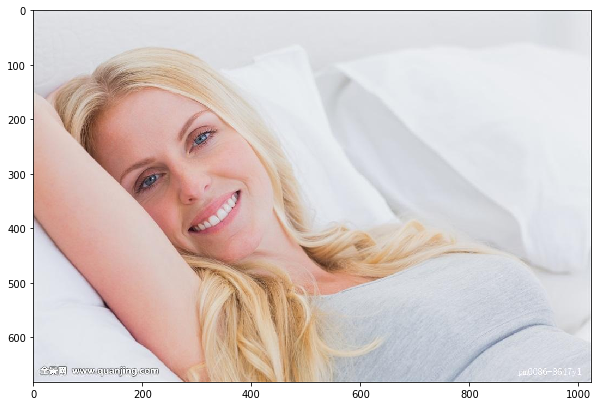

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_file = '../tests/asset/images/roate.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

### Load the mtcnn model.

In [3]:
import mtcnn
from mtcnn.utils import draw


# First we create pnet, rnet, onet, and load weights from caffe model.
pnet, rnet, onet = mtcnn.get_net_caffe('../output/converted')

# Then we create a detector
detector = mtcnn.FaceDetector(pnet, rnet, onet, device='cpu')

### Crop the face from original image.

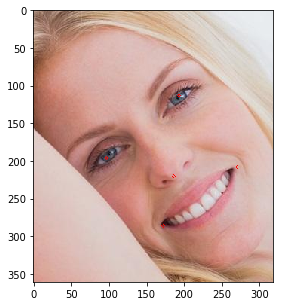

In [4]:
img = cv2.imread(img_file)
boxes, landmarks = detector.detect(img, minsize=24)
face = draw.crop(img, boxes=boxes, landmarks=landmarks)[0]
face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

### Align face through facial landmark points.

#### How can we get the transform matrix.
First we need reference points. Suppose I want to cut the face size to　(112×96), where is the correct facial point in the (112×96) image.

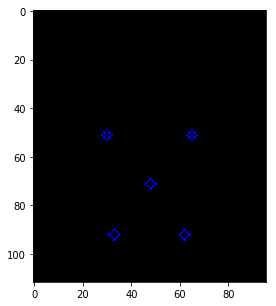

In [5]:
# Define the correct points.
REFERENCE_FACIAL_POINTS = np.array([
    [30.29459953,  51.69630051],
    [65.53179932,  51.50139999],
    [48.02519989,  71.73660278],
    [33.54930115,  92.3655014],
    [62.72990036,  92.20410156]
], np.float32)

# Lets create a empty image|
empty_img = np.zeros((112,96,3), np.uint8) 
draw.draw_landmarks(empty_img, REFERENCE_FACIAL_POINTS.astype(int))

plt.figure(figsize=(5, 5))
plt.imshow(empty_img)
plt.show()

### So where is the face.

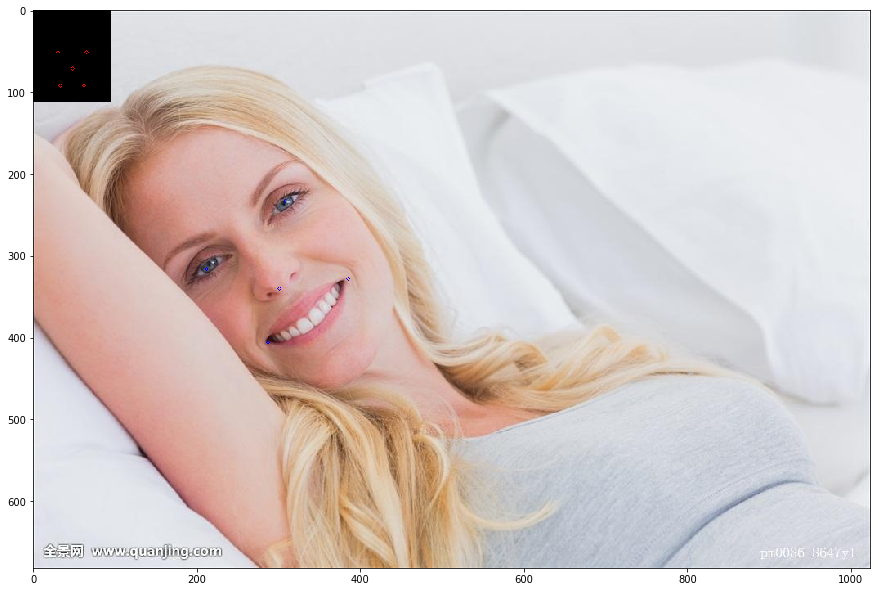

In [6]:
img_copy = img.copy()
landmark = landmarks[0]

img_copy[:112, :96, :] = empty_img
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
draw.draw_landmarks(img_copy, landmark)

plt.figure(figsize=(15, 15))
plt.imshow(img_copy)
plt.show()

### So we need a matrix to transform blue points to red points.
As we know, it's easy to ｄetermine a transformation matrix by three points. So there is a easy solution. We can just take the two points of eyes and the one point of nose. Then we can use function "cv2.getAffineTransform" to get the transformation matrix.

In [7]:
trans_matrix = cv2.getAffineTransform(landmark[:3].cpu().numpy().astype(np.float32), REFERENCE_FACIAL_POINTS[:3])

Next step, apply transformation to origin image and crop the interested region.

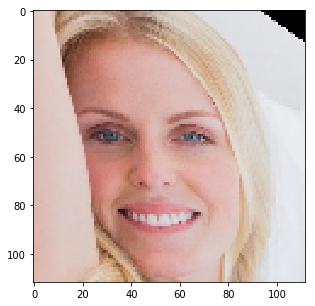

In [8]:
aligned_face = cv2.warpAffine(img.copy(), trans_matrix, (112, 112))
aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(aligned_face)
plt.show()

The face has been aligned, but not pretty good. There are some deformations in the face. 

### So lets implement a more precise alignment.

Can we use the whole five points instead of three of them　and don't do shearing transformation? The answer is yes.

##### So lets recap the knowledge of transformation.
What's the transformation matrix looks like when we want to pan $t_x$ pixels on coordinate　'x' and $t_y$ pixels on coordinate 'y'.
$$A=
\left\{
 \begin{array}{ccc}
     0 & 0 & t_x  \\
     0 & 0 & t_y   \\
     0 & 0 & 1   \\ 
  \end{array} 
\right\}
$$

What's the transformation matrix looks like when we want to rotate the image $\theta$ arc clockwise
$$B=
\left\{
 \begin{array}{ccc}
     cos(\theta) & -sin(\theta) & 0  \\
     sin(\theta) & cos(\theta) & 0   \\
     0 & 0 & 1   \\ 
  \end{array} 
\right\}
$$

So Let $cos(\theta)$ be equal to a, $sin(\theta)$ be equal to b, we got:
$$C=
\left\{
 \begin{array}{ccc}
     a & -b & t_x  \\
     b & a & t_y   \\
     0 & 0 & 1   \\ 
  \end{array} 
\right\}
$$

Given an point 
$P_{origin}=\left\{
 \begin{array}{c}
     x   \\
     y    \\
     1   \\ 
  \end{array} 
\right\}$ 
output from mtcnn and a ｃorresponding point 
$P_{ref}=\left\{
 \begin{array}{c}
     x^,   \\
     y^,    \\
     1,   \\ 
  \end{array} 
\right\}$, We want to find the best parameter for a, b, px, py which satisfy $P_{origin}^T * C^T  = P_{ref}^T $

##### How we solve this equation
$P_{origin}^T * C^T=\left\{
 \begin{array}{ccc}
     ax-by+t_x, & bx+ay+t_y, & 1  \\
  \end{array} 
\right\}=\left\{
 \begin{array}{cccc}
     x & -y & 1 &0  \\
     x & y & 0 & 1 \\
  \end{array} 
\right\} * \left\{
 \begin{array}{c}
     a  \\
     b \\
     t_x \\
     t_y \\
  \end{array} 
\right\} = \left\{
 \begin{array}{c}
     x^,\\
     y^, \\
  \end{array} 
\right\} $

This is a linear equation, we can use **Least Squares Method** to Find approximate solutions on these five points.

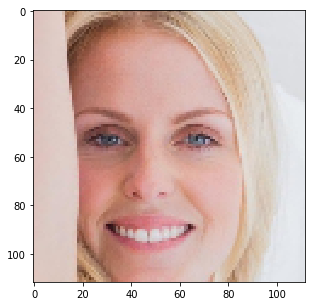

In [9]:
from numpy.linalg import inv, norm, lstsq
from numpy.linalg import matrix_rank as rank

def findNonreflectiveSimilarity(uv, xy, K=2):

    M = xy.shape[0]
    x = xy[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    y = xy[:, 1].reshape((-1, 1))  # use reshape to keep a column vector

    tmp1 = np.hstack((x, y, np.ones((M, 1)), np.zeros((M, 1))))
    tmp2 = np.hstack((y, -x, np.zeros((M, 1)), np.ones((M, 1))))
    X = np.vstack((tmp1, tmp2))

    u = uv[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    v = uv[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    U = np.vstack((u, v))

    # We know that X * r = U
    if rank(X) >= 2 * K:
        r, _, _, _ = lstsq(X, U)
        r = np.squeeze(r)
    else:
        raise Exception('cp2tform:twoUniquePointsReq')

    sc = r[0]
    ss = r[1]
    tx = r[2]
    ty = r[3]

    Tinv = np.array([
        [sc, -ss, 0],
        [ss,  sc, 0],
        [tx,  ty, 1]
    ])


    T = inv(Tinv)

    T[:, 2] = np.array([0, 0, 1])

    T = T[:, 0:2].T

    return T

similar_trans_matrix = findNonreflectiveSimilarity(landmark.cpu().numpy().astype(np.float32), REFERENCE_FACIAL_POINTS)

aligned_face = cv2.warpAffine(img.copy(), similar_trans_matrix, (112, 112))
aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(aligned_face)
plt.show()

Pretty good, isn't it?